# Run AR6-fair for illustrative path way scenarios from AR6 extended to 2300.


These start in 2015 so with @mo-gregmunday we have merged the illustrative pathways from AR6 with RCMIP historical data so the data can start from 1750 and we have extended these using Meinshausen to go to 2300. The processing to join with RCMIP data happens in this notebook: ar6_fixer.ipynb and the processing to extend happens in a separate repository.

In this notebook we use the AR6 parameter settings to run a constrained ensemble 
    
    * plot the emissions for some of the pathways
    
    * run the 8 pathways through FaIR (this now appears to be working), 
    
    * plot some fields (currently only for the first model) to ensure all is well, 
    
    * output to a csv file.


In [104]:
import fair
import matplotlib.pyplot as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy.interpolate import interp1d
from multiprocessing import Pool
from tqdm import tqdm
import json
import pickle
#from climateforcing.twolayermodel import TwoLayerModel
from climateforcing.utils import check_and_download, mkdir_p
import os

In [150]:
# set up plotting
pl.rcParams['figure.figsize'] = (9/1.5, 9/2)
pl.rcParams['font.size'] = 12
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['xtick.direction'] = 'out'
pl.rcParams['ytick.direction'] = 'out'
pl.rcParams['xtick.minor.visible'] = True
pl.rcParams['ytick.major.left'] = True
pl.rcParams['ytick.major.right'] = True
pl.rcParams['ytick.minor.visible'] = True
pl.rcParams['xtick.top'] = True
pl.rcParams['ytick.right'] = True

In [148]:
# Download FaIR params set
check_and_download(
    'https://zenodo.org/record/5513022/files/fair-1.6.2-wg3-params.json', 
    '../data_input/fair_ar6/'
)

In [107]:
with open('../data_input/fair_ar6/fair-1.6.2-wg3-params.json') as f:
    config_list = json.load(f)

In [108]:
len(config_list)

2237

In [109]:
for k in config_list[0].keys():
    print (k)
    

F2x
r0
rt
rc
lambda_global
ocean_heat_capacity
ocean_heat_exchange
deep_ocean_efficacy
b_aero
ghan_params
scale
C_pi
E_pi
ghg_forcing
aCO2land
stwv_from_ch4
F_ref_BC
E_ref_BC
F_solar
F_volcanic
tropO3_forcing
b_tro3
ozone_feedback
natural


In [110]:
rt_list = []
for c in config_list:
    rt_list.append(c['natural'])
print(len(rt_list[0]))

361


In [111]:
rt_list = []
for c in config_list:
    rt_list.append(c["natural"])
print(rt_list[0][0])
print(rt_list[0][1])
print(rt_list[1][0])
print(rt_list[1][1])
len(rt_list[:])

[192.9865502785643, 11.137730226696137]
[194.26764846814376, 11.281236291135704]
[192.9865502785643, 11.137730226696137]
[194.26764846814376, 11.281236291135704]


2237

In [112]:
with open('../data_input/fair_ar6/fair-1.6.2-wg3-params.json', "r") as infile:
    all_data = json.load(infile)
    
    # COULD BE: for data in all_data: ... if you don't want to just see the first index
    #data = all_data[0]
    
    for data in all_data:
        for key in data:
            val = data[key]
            # if the value is a list of length 401
            if type(val) == list and len(val) == 361:
                #print(key)
                # for i in range(400 - len(val)): # IF 401 IS HARD CODED, THIS LINE IS UNNECESSARILY COMPLICATED
                for i in range(190):
                    # add the final value 400 - n times
                    val.append(val[-1])
        #print(data)
            
    with open("fair-1.6.2-wg3-params-extended-2300.json", "w") as outfile:
        # this dumps ALL DATA into the new JSON file
        json.dump(all_data, outfile)
        # alternatively, you can dump only THE EDITED DATA with:
        #json.dump(data, outfile)

# double checks it changes as needed
with open("fair-1.6.2-wg3-params-extended-2300.json", "r") as infile:
    extended_data = json.load(infile)
    print(len(extended_data))
    
    new_rt_list = []
    for c in extended_data:
        new_rt_list.append(c['F_solar'])
    print (len(new_rt_list[0]))

2237
551


In [113]:
with open("fair-1.6.2-wg3-params-extended-2300.json", "r") as infile:
    extended_data = json.load(infile)
    print(len(extended_data))
    
    new_rt_list = []
    for c in extended_data:
        new_rt_list.append(c['F_solar'])
    print ('F_solar',len(new_rt_list[0]))
    
    new_rt_list = []
    for c in extended_data:
        new_rt_list.append(c['F_volcanic'])
    print ('F_volcanic',len(new_rt_list[0]))
    
    new_rt_list = []
    for c in extended_data:
        new_rt_list.append(c['natural'])
        #print(new_rt_list)
    print ('natural',len(new_rt_list[0]))

2237
F_solar 551
F_volcanic 551
natural 551


In [114]:
#scenarios = ['constant_forcing', 'constant_emissions', 'zero', 'scenario', 'infrastructure']
#scenarios = ['constant_emissions', 'zero', 'infrastructure', 'scenario']
# zero and constant emissions will be the easy ones, so start with these.

scenarios = ['CO_Bridge', 
             'DeepElec_SSP2_ HighRE_Budg900', 
             #'EN_INDCi2030_500f', 
             'EN_NPi2020_400f_lowBECCS', 
             'EN_NPi2020_900f',
             'SSP2_openres_lc_50',
             'SusDev_SDP-PkBudg1000',
             'LowEnergyDemand_1.3_IPCC' 
            ]

len(scenarios)

7

In [115]:
# Download RCMIP emissions
#check_and_download(
#    'https://zenodo.org/record/4589756/files/rcmip-emissions-annual-means-v5-1-0.csv', 
#    '../data_input/rcmip/'
#)

In [116]:
# Download illustrative pathways
#AR6Pathways = pd.read_csv(
#    '/home/h02/hadcam/github/IllusPathwaysAR6_data/AR6Illus_RCMIP.csv')
    #20210928_ar6emissions_harmonized_infilled_c1_c3_IPs_plus_c2.csv')


#RCMIPhist_data = pd.read_csv('/home/h02/hadcam/github/IllusPathwaysAR6/plushistRCMIP.csv')

#plushist = pd.read_csv('/home/h02/hadcam/github/IllusPathwaysAR6/plushistRCMIP.csv')
#plushist_long = pd.melt(plushist, id_vars=['Model', 'Scenario', 'Region', 'Variable', 'Unit', 'Mip_Era', 'Activity_Id'], var_name='Year')
#rcmip_ar6 = pd.read_csv('/home/h02/hadcam/github/IllusPathwaysAR6/IllusPathsAR6_plushistRCMIP.csv')
#rcmip_ar6_long = pd.melt(rcmip_ar6, id_vars=['Model', 'Scenario', 'Region', 'Variable', 'Unit'], var_name='Year')
#plushist_long.drop(columns=['Mip_Era', 'Activity_Id'], inplace=True)
#rcmip_alldata = pd.concat([plushist_long, rcmip_ar6_long])

#sns.relplot(data=rcmip_alldata, x='Year', y='value', hue='Model')
#g = sns.relplot(data=rcmip_alldata, x='Year', y='value', hue='Model')

#rcmip_alldata.to_csv('/home/h02/hadcam/github/IllusPathwaysAR6/AR6Ilusplus_RCMIPhist.csv')

In [117]:
#new = pd.DataFrame.stack(rcmip_alldata)
#new.to_csv('/home/h02/hadcam/github/IllusPathwaysAR6/AR6Ilusplus_RCMIPhist_wide.csv')

#rcmip_data_wide.to_csv('/home/h02/hadcam/github/IllusPathwaysAR6/AR6Ilusplus_RCMIPhist.csv')

In [203]:
# Download illustrative pathways
#illuspd = pd.read_csv(
#    '/home/h02/hadcam/github/IllusPathwaysAR6/20210928_ar6emissions_harmonized_infilled_c1_c3_IPs_plus_c2.csv')

ssp_df= pd.read_csv('/data/users/hadcam/scenarios_extend/data_processed/infilled_extended/IMP_scenario_emissions_1750_2300.csv')

#fill_years = [str(x) for x in range(2100, 2111)]
#for yr in fill_years:
#    ssp_df.loc[:, yr] = ssp_df[yr].fillna(ssp_df['2100'])

years = np.arange(1750, 2301) # 551
startyear = 1750            
first_scenyear = 2015
last_scenyear = 2300
first_row = int(first_scenyear-startyear) # 265
print(first_row)
last_row = int(last_scenyear-startyear)   # 550
print(last_row)

species = [  # in fair 1.6, order is important
    '|CO2|Energy and Industrial Processes', #'MAGICC Fossil and Industrial',
    '|CO2|AFOLU', #'MAGICC AFOLU'
    '|CH4',
    '|N2O',
    '|Sulfur',
    '|CO',
    '|VOC',
    '|NOx',
    '|BC',
    '|OC',
    '|NH3',
    '|PFC|CF4',
    '|PFC|C2F6',
    '|PFC|C6F14',
    '|HFC|HFC23',
    '|HFC|HFC32',
    '|HFC|HFC43-10', # 'HFC4310mee'
    '|HFC|HFC125',
    '|HFC|HFC134a',
    '|HFC|HFC143a',
    '|HFC|HFC227ea',
    '|HFC|HFC245fa', #'HFC245ca'
    '|SF6',
    '|CFC11',
    '|CFC12',
    '|CFC113',
    '|CFC114',
    '|CFC115',
    '|CCl4',
    '|CH3CCl3',
    '|HCFC22',
    '|HCFC141b',
    '|HCFC142b',
    '|Halon1211',
    '|Halon1202',
    '|Halon1301',
    '|Halon2402',
    '|CH3Br',
    '|CH3Cl',
]

# Assume that units coming out of aneris don't change. One day I'll do unit parsing
unit_convert = np.ones(40)
unit_convert[1] = 12/44/1000
unit_convert[2] = 12/44/1000
unit_convert[4] = 28/44/1000
unit_convert[5] = 32/64
unit_convert[8] = 14/46

data_out = {}


for scenario in scenarios:
    data_out[scenario] = np.ones((551, 40)) * np.nan
    data_out[scenario][:,0] = years
    print(scenario)
    
    for i, specie in enumerate(species):
        #print(first_row, last_row+1)
        #print(data_out[scenario].shape,ssp_df.loc[(ssp_df['region']=='World')&(ssp_df['scenario']==scenario)&
        #                                          (ssp_df['variable'].str.endswith(specie)),
        #                                          str(startyear):'2014'].shape)
        data_out[scenario][:first_row,i+1] = ssp_df.loc[(ssp_df['region']=='World')&(ssp_df['scenario']==scenario)&
                                                        (ssp_df['variable'].str.endswith(specie)),
                                                        str(startyear):'2014']*unit_convert[i+1]
        f =  ssp_df.loc[(ssp_df['region']=='World')&(ssp_df['scenario']==scenario)&
                        (ssp_df['variable'].str.endswith(specie)),'2015':'2300'].dropna(axis=1)*unit_convert[i+1]
        data_out[scenario][(first_row):(last_row+1), i+1] = f

265
550
CO_Bridge
DeepElec_SSP2_ HighRE_Budg900
EN_NPi2020_400f_lowBECCS
EN_NPi2020_900f
SSP2_openres_lc_50
SusDev_SDP-PkBudg1000
LowEnergyDemand_1.3_IPCC


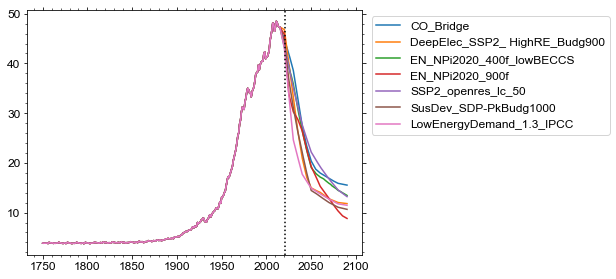

In [204]:
for scenario in scenarios:
    pl.plot(np.arange(1750, 2091), data_out[scenario][:341,8], label=scenario)    
pl.axvline(2021, ls=':', color='k')
pl.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

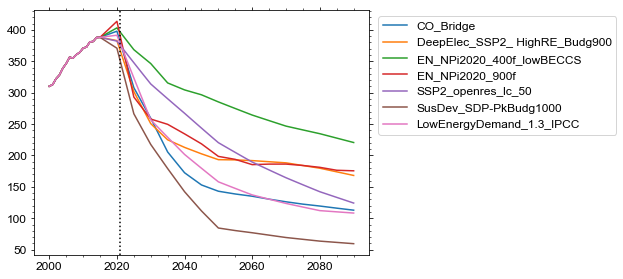

In [205]:
for scenario in scenarios:
    pl.plot(np.arange(2000, 2091), data_out[scenario][250:341,3], label=scenario)    
pl.axvline(2021, ls=':', color='k')
pl.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

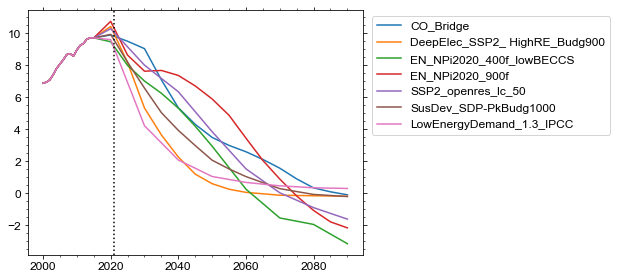

In [206]:
for scenario in scenarios:
    pl.plot(np.arange(2000, 2091), data_out[scenario][250:341,1], label=scenario)    
pl.axvline(2021, ls=':', color='k')
pl.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

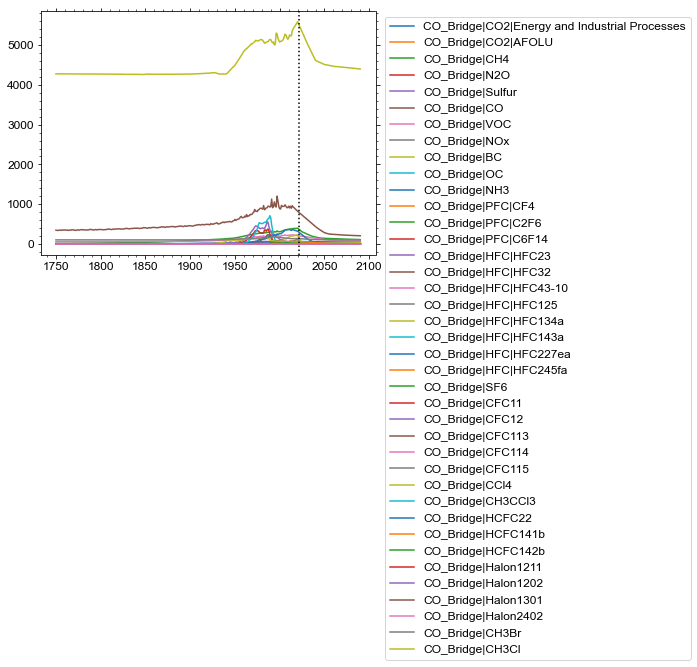

In [207]:
for scenario in ['CO_Bridge']:
    for i, specie in enumerate(species):
        pl.plot(np.arange(1750, 2091), data_out[scenario][:341,i+1], label=scenario+specie)    
pl.axvline(2021, ls=':', color='k')
pl.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

# Try the first illustrative pathway before looping through the rest of them.

In [208]:
results_out = {}

In [209]:
updated_config = []
for i, cfg in enumerate(extended_data):
    updated_config.append({})
    for key, value in cfg.items():
        if isinstance(value, list):
            updated_config[i][key] = np.asarray(value)
        else:
            updated_config[i][key] = value
    updated_config[i]['emissions'] = data_out['CO_Bridge']
    updated_config[i]['diagnostics'] = 'AR6'
    updated_config[i]["efficacy"] = np.ones(45)
    updated_config[i]["gir_carbon_cycle"] = True
    updated_config[i]["temperature_function"] = "Geoffroy"
    updated_config[i]["aerosol_forcing"] = "aerocom+ghan2"
    updated_config[i]["fixPre1850RCP"] = False
    updated_config[i]["scale"][43] = 0.6
    updated_config[i]["F_solar"] = 0.
    updated_config[i]["F_volcanic"] = 0.


In [210]:
print (updated_config[i]['emissions'].shape)
print (updated_config[i]['emissions'])

(551, 40)
[[ 1.75000000e+03  2.59244179e-03  8.11267109e-02 ...  0.00000000e+00
   1.05087730e+02  4.27574490e+03]
 [ 1.75100000e+03  2.59253543e-03  8.26192087e-02 ...  0.00000000e+00
   1.05107200e+02  4.27676850e+03]
 [ 1.75200000e+03  2.59363692e-03  8.41391642e-02 ...  0.00000000e+00
   1.05125020e+02  4.27770490e+03]
 ...
 [ 2.29800000e+03 -0.00000000e+00 -0.00000000e+00 ...  0.00000000e+00
   1.05087730e+02  4.27574490e+03]
 [ 2.29900000e+03 -0.00000000e+00 -0.00000000e+00 ...  0.00000000e+00
   1.05087730e+02  4.27574490e+03]
 [ 2.30000000e+03 -0.00000000e+00 -0.00000000e+00 ...  0.00000000e+00
   1.05087730e+02  4.27574490e+03]]


In [211]:
print (updated_config[i]['natural'].shape)
print (len(updated_config[i]['natural']))

(551, 2)
551


(551, 2)
551
2237


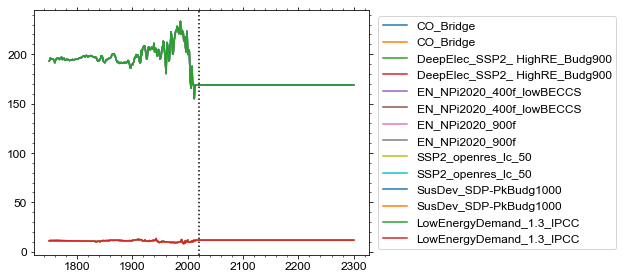

In [212]:
#print(updated_config[i]['natural'])
print (updated_config[i]['natural'].shape)
#print (updated_config[i]['natural'])
print (len(updated_config[i]['natural']))
print (len(updated_config))
for scenario in scenarios:
    pl.plot(np.arange(1750, 2301), updated_config[i]['natural'], label=scenario)    
pl.axvline(2021, ls=':', color='k')
pl.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

In [213]:
def run_fair(args):
    thisC, thisF, thisT, _, thisOHU, _, thisAF = fair.forward.fair_scm(**args)
    return (thisC[:,0], thisT, np.sum(thisF[:,:43], axis=1), np.sum(thisF[:,35:41], axis=1), np.sum(thisF, axis=1))

if __name__ == '__main__':
    with Pool(28) as pool:
        result = list(tqdm(pool.imap(run_fair, updated_config), total=len(updated_config)))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [01:40<00:00, 22.15it/s]


In [215]:
len(result[0])

5

In [216]:
len(updated_config)

2237

In [217]:
result_t = np.array(result).transpose(1,2,0)

In [218]:
results_out['CO_Bridge'] = {}
c, t, f_ant, f_aer, f_tot = result_t
temp_rebase = t - t[100:151,:].mean(axis=0)
results_out['CO_Bridge']['co2_conc'] = c
results_out['CO_Bridge']['temp'] = temp_rebase
results_out['CO_Bridge']['F_ant'] = f_ant
results_out['CO_Bridge']['F_aer'] = f_aer
results_out['CO_Bridge']['F_tot'] = f_tot

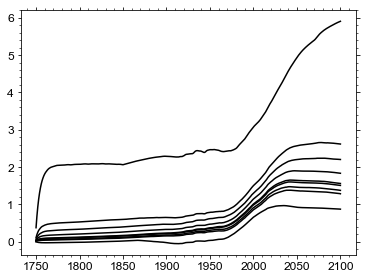

In [219]:
#temp_df = pd.read_csv('../data_input/observations/temp.csv', index_col=0)
#temp_df

for perc in [0,5,10,20,25,50,75,90,100]:
    pl.plot(np.arange(1750,2101),np.percentile(t[:351],perc, axis=1), color='k')


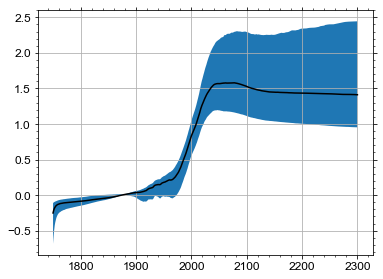

In [220]:
pl.fill_between(np.arange(1750,2301), np.percentile(results_out['CO_Bridge']['temp'], 5, axis=1), np.percentile(results_out['CO_Bridge']['temp'], 95, axis=1))
pl.plot(np.arange(1750,2301), np.percentile(results_out['CO_Bridge']['temp'], 50, axis=1), color='k')
#pl.plot(temp_df.index, temp_df.temp, color='r')
#pl.ylim(0.0, 1.7)
#pl.xlim(1950, 2030)
pl.grid()

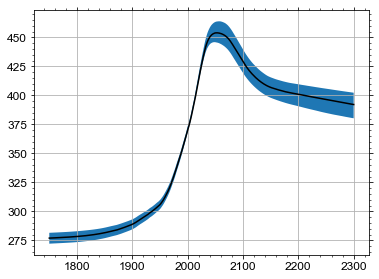

In [221]:
pl.fill_between(np.arange(1750,2301), np.percentile(results_out['CO_Bridge']['co2_conc'], 5, axis=1), np.percentile(results_out['CO_Bridge']['co2_conc'], 95, axis=1))
pl.plot(np.arange(1750,2301), np.percentile(results_out['CO_Bridge']['co2_conc'], 50, axis=1), color='k')
#pl.plot(temp_df.index, temp_df.temp, color='r')
#pl.ylim(0.0, 1.7)
#pl.xlim(1950, 2030)
pl.grid()

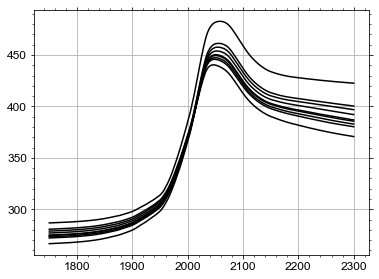

In [222]:
for perc in [0,5,10,20,25,50,75,90,100]:
    pl.plot(np.arange(1750,2301),np.percentile(c,perc, axis=1), color='k')
pl.grid()

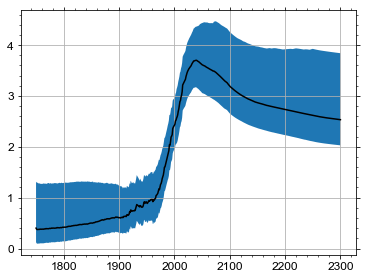

In [223]:
pl.fill_between(np.arange(1750,2301), np.percentile(f_ant, 5, axis=1), np.percentile(f_ant, 95, axis=1))
pl.plot(np.arange(1750,2301), np.percentile(f_ant, 50, axis=1), color='k')
pl.grid()

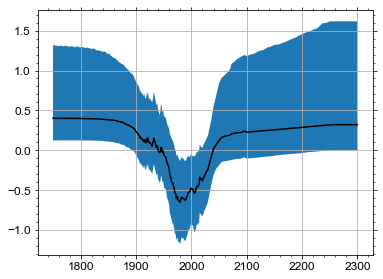

In [224]:
pl.fill_between(np.arange(1750,2301), np.percentile(f_aer, 5, axis=1), np.percentile(f_aer, 95, axis=1))
pl.plot(np.arange(1750,2301), np.percentile(f_aer, 50, axis=1), color='k')
pl.grid()

In [225]:
np.median(results_out['CO_Bridge']['temp'], axis=1)[245:265].mean()

0.9198330774592417

In [226]:
# aerosol forcing is a little less negative than in WG3 because we use CEDS-updated not SSP historical
print(
    np.percentile(results_out['CO_Bridge']['F_aer'], 5, axis=1)[255:265].mean(),
    np.percentile(results_out['CO_Bridge']['F_aer'], 50, axis=1)[255:265].mean(),
    np.percentile(results_out['CO_Bridge']['F_aer'], 95, axis=1)[255:265].mean()
)

-0.9632399791397942 -0.4809178192165625 -0.03881430172779256


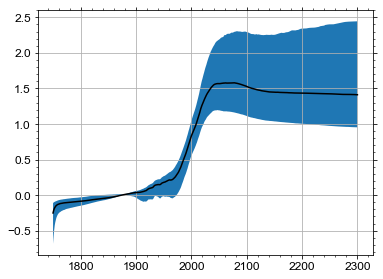

In [227]:
pl.fill_between(np.arange(1750,2301), np.percentile(results_out['CO_Bridge']['temp'], 5, axis=1), np.percentile(results_out['CO_Bridge']['temp'], 95, axis=1))
pl.plot(np.arange(1750,2301), np.percentile(results_out['CO_Bridge']['temp'], 50, axis=1), color='k')
#pl.plot(temp_df.index, temp_df.temp, color='r')
#pl.ylim(0.0, 1.7)
#pl.xlim(1950, 2030)
pl.grid()

# Loop through the other illustrative pathways

CO_Bridge


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [01:44<00:00, 21.47it/s]


DeepElec_SSP2_ HighRE_Budg900


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [01:44<00:00, 21.48it/s]


EN_NPi2020_400f_lowBECCS


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [01:43<00:00, 21.61it/s]


EN_NPi2020_900f


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [01:53<00:00, 19.71it/s]


SSP2_openres_lc_50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [01:58<00:00, 18.82it/s]


SusDev_SDP-PkBudg1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [01:51<00:00, 20.04it/s]


LowEnergyDemand_1.3_IPCC


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [01:47<00:00, 20.86it/s]


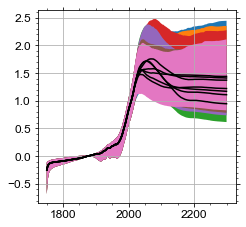

In [144]:
results_out = {}
for scenario in scenarios:
    print (scenario)
    results_out[scenario]={}
    
    updated_config = []
    for i, cfg in enumerate(extended_data):
        updated_config.append({})
        for key, value in cfg.items():
            if isinstance(value, list):
                updated_config[i][key] = np.asarray(value)
            else:
                updated_config[i][key] = value
        updated_config[i]['emissions'] = data_out[scenario]
        updated_config[i]['diagnostics'] = 'AR6'
        updated_config[i]["efficacy"] = np.ones(45)
        updated_config[i]["gir_carbon_cycle"] = True
        updated_config[i]["temperature_function"] = "Geoffroy"
        updated_config[i]["aerosol_forcing"] = "aerocom+ghan2"
        updated_config[i]["fixPre1850RCP"] = False
        updated_config[i]["scale"][43] = 0.6
        updated_config[i]["F_solar"] = 0.
        updated_config[i]["F_volcanic"] = 0.
    
    def run_fair(args):
        thisC, thisF, thisT, _, thisOHU, _, thisAF = fair.forward.fair_scm(**args)
        return (thisC[:,0], thisT, np.sum(thisF[:,:43], axis=1), np.sum(thisF[:,35:41], axis=1), np.sum(thisF, axis=1))

    if __name__ == '__main__':
        with Pool(28) as pool:
            result = list(tqdm(pool.imap(run_fair, updated_config), total=len(updated_config)))
    
    #results_out[scenario] = {}
    result_t = np.array(result).transpose(1,2,0)
    c, t, f_ant, f_aer, f_tot = result_t
    temp_rebase = t - t[100:151,:].mean(axis=0)
    temp_rebase_1995_2014 = t - t[245:265,:].mean(axis=0) # subtract 1995-2014 mean  
    
    results_out[scenario]['co2_conc'] = c
    results_out[scenario]['temp'] = temp_rebase
    results_out[scenario]['temp_2'] = temp_rebase_1995_2014
    results_out[scenario]['F_ant'] = f_ant
    results_out[scenario]['F_aer'] = f_aer
    results_out[scenario]['F_tot'] = f_tot

    pl.fill_between(np.arange(1750,2301), np.percentile(results_out[scenario]['temp'], 5, axis=1), np.percentile(results_out[scenario]['temp'], 95, axis=1))
    pl.plot(np.arange(1750,2301), np.percentile(results_out[scenario]['temp'], 50, axis=1), color='k')
    pl.grid()
    

CO_Bridge


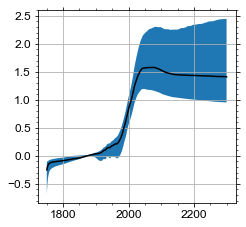

DeepElec_SSP2_ HighRE_Budg900


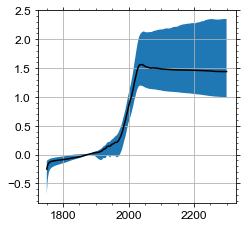

EN_NPi2020_400f_lowBECCS


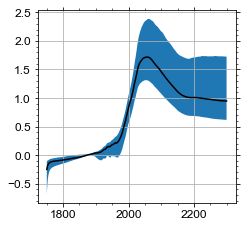

EN_NPi2020_900f


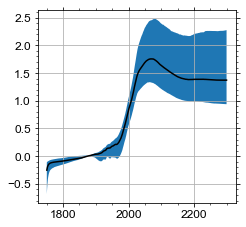

SSP2_openres_lc_50


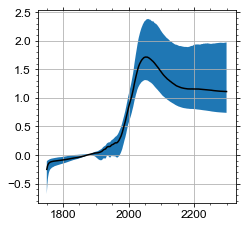

SusDev_SDP-PkBudg1000


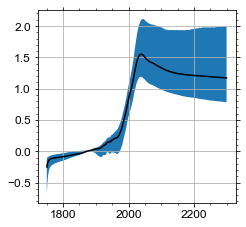

LowEnergyDemand_1.3_IPCC


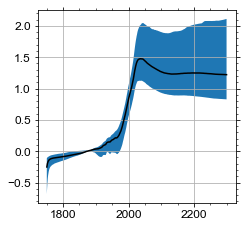

In [145]:
for scenario in scenarios:
    print (scenario)
    pl.fill_between(np.arange(1750,2301), np.percentile(results_out[scenario]['temp'], 5, axis=1), 
                    np.percentile(results_out[scenario]['temp'], 95, axis=1))
    pl.plot(np.arange(1750,2301), np.percentile(results_out[scenario]['temp'], 50, axis=1), color='k')
    #pl.plot(temp_df.index, temp_df.temp, color='r')
    pl.grid()
    pl.pause(5)
   

# All on the same plot!

In [ ]:
colors = {#'EN_INDCi2030_500f': 'purple', 
        'DeepElec_SSP2_ HighRE_Budg900': 'blue',  
        'SusDev_SDP-PkBudg1000':'pink',
        'LowEnergyDemand_1.3_IPCC':'purple' ,
        'EN_NPi2020_400f_lowBECCS': 'cyan', 
        'EN_NPi2020_900f': 'orange',      
        'SSP2_openres_lc_50': 'green',      
        'CO_Bridge': 'red', 
         }
labels = {#'EN_INDCi2030_500f':'EN_INDCi2030_500f', 
          'DeepElec_SSP2_ HighRE_Budg900':'C1: IMP-Ren', 
          'SusDev_SDP-PkBudg1000':'C1: IMP-SP',
          'LowEnergyDemand_1.3_IPCC':'C1: IMP-LD',
          'EN_NPi2020_400f_lowBECCS':'C2: IMP-Neg', 
          'EN_NPi2020_900f':'C3: Neg-2.0',
          'SSP2_openres_lc_50':'C3: IMP-Ren-2.0',
          'CO_Bridge':'C3: IMP-GS',
           }

In [ ]:
fig, ax = pl.subplots(figsize=(12, 10))

ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.text(0.02, 0.94, 'Scenario', fontweight='bold', fontsize=15, transform=ax.transAxes)
for i, scenario in enumerate(scenarios):
    ax.fill_between(np.arange(2000,2301), np.percentile(results_out[scenario]['temp'][250:551,:] - results_out[scenario]['temp'][271,:], 5, axis=1), np.percentile(results_out[scenario]['temp'][250:351,:] - results_out[scenario]['temp'][271,:], 95, axis=1), color=colors[scenario], alpha=0.2)
    ax.plot(np.arange(2000, 2301), np.median(results_out[scenario]['temp'][250:551,:] - results_out[scenario]['temp'][271,:], axis=1), color=colors[scenario], label=labels[scenario])
    ax.text(0.02, 0.88-0.06*i, labels[scenario], color=colors[scenario], transform=ax.transAxes, fontsize=15)
#ax.legend(fontsize=10);
ax.set_ylabel('°C relative to 2021', fontsize=18);
ax.set_title('Global warming associated with different IPCC WGIII IMPs', fontsize=18);
ax.set_xlim(2000, 2300)
ax.set_ylim(-0.5, 1.5)

from matplotlib import ticker

ax1 = ax.twinx()
positions = np.arange(0.75, 2.76, 0.25)

ax1.yaxis.set_major_locator(ticker.FixedLocator(positions))

ax1.set_ylim(0.75,2.75)
ax1.spines['right'].set_color('gray')
ax1.tick_params(axis='y', colors='gray')
ax1.set_ylabel('°C relative to 1850-1900', color='gray', fontsize=18)


ax.axhline(0, ls=':', color='k', lw=0.5)
ax1.axhline(1.5, ls='-.', color='k', lw=0.5)
ax1.axhline(1.75, ls='-.', color='k', lw=0.5)
ax1.axhline(2.0, ls='-', color='k', lw=0.5)
fig.tight_layout()
pl.savefig('../plots/rcmip_illus_scenarios_temp_allIMPS_2300.png', dpi=500, transparent=False)

# All on the same plot CO2 conc!

In [ ]:
fig, ax = pl.subplots(figsize=(12, 10))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.text(0.02, 0.94, 'Scenario', fontweight='bold', fontsize=15, transform=ax.transAxes)
for i, scenario in enumerate(scenarios):
    ax.fill_between(np.arange(2000,2301), np.percentile(results_out[scenario]['co2_conc'][250:551,:] - results_out[scenario]['co2_conc'][271,:], 5, axis=1), np.percentile(results_out[scenario]['co2_conc'][250:551,:] - results_out[scenario]['co2_conc'][271,:], 95, axis=1), color=colors[scenario], alpha=0.2)
    ax.plot(np.arange(2000, 2301), np.median(results_out[scenario]['co2_conc'][250:551,:] - results_out[scenario]['co2_conc'][271,:], axis=1), color=colors[scenario], label=labels[scenario])
    ax.text(0.02, 0.88-0.06*i, labels[scenario], color=colors[scenario], transform=ax.transAxes, fontsize=15)
#ax.legend(fontsize=10);
ax.set_ylabel(r'CO${_2}$ concentration (ppm)', fontsize=20);
ax.set_title(r'CO${_2}$ concentration associated with different IPCC WGIII IMPs', fontsize=20);
ax.set_xlim(2000, 2100)
#ax.set_ylim(-0.5, 1.5)

from matplotlib import ticker


ax1.yaxis.set_major_locator(ticker.FixedLocator(positions))

ax1.spines['right'].set_color('gray')
ax1.tick_params(axis='y', colors='gray')

fig.tight_layout()
pl.savefig('../plots/rcmip_illus_scenarios_CO2conc_allIMPS_2300.png', dpi=500, transparent=False)

# All on the same plot ERF!

In [ ]:
fig, ax = pl.subplots(figsize=(12, 10))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.text(0.02, 0.94, 'Scenario', fontweight='bold', fontsize=10, transform=ax.transAxes)
for i, scenario in enumerate(scenarios):
    ax.fill_between(np.arange(2000,2301), np.percentile(results_out[scenario]['F_tot'][250:551,:] - results_out[scenario]['F_tot'][271,:], 5, axis=1), np.percentile(results_out[scenario]['F_tot'][250:351,:] - results_out[scenario]['F_tot'][271,:], 95, axis=1), color=colors[scenario], alpha=0.2)
    ax.plot(np.arange(2000, 2301), np.median(results_out[scenario]['F_tot'][250:551,:] - results_out[scenario]['F_tot'][271,:], axis=1), color=colors[scenario], label=labels[scenario])
    ax.text(0.02, 0.88-0.06*i, labels[scenario], color=colors[scenario], transform=ax.transAxes, fontsize=10)
#ax.legend(fontsize=10);
ax.set_ylabel(r'Radiative Forcing (Wm${^-2}$)');
ax.set_title('Effective Radiative Forcing associated with different ssp scenarios');
ax.set_xlim(2000, 2300)
#ax.set_ylim(-0.5, 1.5)

from matplotlib import ticker


ax1.yaxis.set_major_locator(ticker.FixedLocator(positions))

ax1.spines['right'].set_color('gray')
ax1.tick_params(axis='y', colors='gray')

fig.tight_layout()
pl.savefig('../plots/rcmip_illus_scenarios_erf.png', dpi=500, transparent=False)

In [ ]:
### Plot rebased to preindustrial

In [ ]:
cmsize=(17,12)
fsize=10
dpi_display=500
fontfam = "Arial"
pl.subplots(figsize=(20, 12))

fig.suptitle("Evolution of mean temperature change for AR6 Illustrative pathways",size=12)
#scenarios = ['zero', 'constant_forcing', 'constant_emissions', 'infrastructure', 'scenario']
#scenarios = ['ssp119',  'ssp126', 'ssp245', 'ssp370', 'ssp434', 'ssp585']
# Removed the 1995-2014 mean and added the observed warming of 0.85 onto this
#fig, ax = pl.subplots(figsize=(12, 10))

ax=plt.subplot2grid((1,5),(0,0),colspan=3)
ax1=plt.subplot2grid((1,5),(0,3))
#ax1=plt.subplots_adjust(wspace=0.1)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.tick_params(axis='both', which='minor', labelsize=18)
#ax.text(0.02, 0.94, 'Scenario', fontweight='bold', fontsize=20, transform=ax.transAxes)

for i, scenario in enumerate(scenarios):
    #ax.fill_between(np.arange(2000,2101), 
    #                np.percentile(results_out[scenario]['temp_2'][250:351,:]+0.85 , 5, axis=1), 
    #                np.percentile(results_out[scenario]['temp_2'][250:351,:]+0.85 , 95, axis=1), 
    #                color=colors[scenario], alpha=0.2)
    ax.plot(np.arange(2000, 2101), np.median(results_out[scenario]['temp'][250:351,:] , axis=1), color=colors[scenario],linewidth=3, label=labels[scenario])
    #ax.text(0.02, 0.88-0.06*i, labels[scenario], color=colors[scenario], transform=ax.transAxes, fontsize=20)
ax.legend();
ax.set_title('Global warming associated with AR6 illustrative pathways', fontsize=20);
ax.set_xlim(2000, 2100)
#ax.set_ylim(-0.5, 1.5)

from matplotlib import ticker

#ax1 = ax.twinx()
#positions = np.arange(0.75, 2.76, 0.25)
#ax.yaxis.set_major_locator(ticker.FixedLocator(positions))

#ax.set_ylim(0.75,2.75)
ax.spines['right'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.set_ylabel('°C relative to 1995-2014', color='gray',fontsize=20)
ax.set_xlabel('Year', color='gray',fontsize=20)
pl.axvline(2021, ls=':', color='k')

ax.axhline(1, ls=':', color='k', lw=0.5)
ax.axhline(1.5, ls='-.', color='k', lw=0.5)
ax.axhline(1.75, ls='-.', color='k', lw=0.5)
ax.axhline(2.0, ls='-', color='k', lw=0.5)

ax1=plt.subplot2grid((1,5),(0,3),sharey=ax)


for i, scenario in enumerate(scenarios):
    data = results_out[scenario]['temp'][250:351,:]
    
    fifth = np.percentile(results_out[scenario]['temp'][250:351,:], 5, axis=1) 
    twentyfifth= np.percentile(results_out[scenario]['temp'][250:351,:], 25, axis=1)
    middle = np.percentile(results_out[scenario]['temp'][250:351,:], 50, axis=1)
    seventyfifth = np.percentile(results_out[scenario]['temp'][250:351,:], 75, axis=1)
    ninetyfifth = np.percentile(results_out[scenario]['temp'][250:351,:], 95, axis=1)
    
    print('5th               25th                    50th                    75th                     95th')
    print(np.mean(fifth), np.mean(twentyfifth), np.mean(middle), np.mean(seventyfifth), np.mean(ninetyfifth))
    
    
    ax1.plot([i+1,i+1],[np.mean(fifth),np.mean(ninetyfifth)], linewidth=10,color=colors[scenario], alpha=0.2)
    #ax1.plot([i+1,i+1],[np.median(middle)-0.001,np.median(middle)+0.001],linewidth=5,color=colors[scenario])
    ax1.plot([i+1,i+1],[middle[95],middle[96]],linewidth=5,color=colors[scenario])
    
plotlabels=['C3','C1','C2','C3','C3','C1','C1']    
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='minor', labelsize=15)
ax1=plt.gca().set_xticklabels(plotlabels)
ax1=plt.gca().set_xticks([ 1, 2, 3, 4, 5, 6, 7])

#ax1.set_xlabel('Scenario', color='gray',fontsize=20)
#ax1.grid()
#fig.tight_layout()
pl.savefig('plots/All_IMPS_overshoot_illusPathways_scenarios_noplumetemp_PI.png', dpi=500, transparent=False)

#for scenario in scenarios:
#    print(scenario, len(np.median(results_out[scenario]['temp_2'][250:351,:]+0.85 , axis=1)))
#    #print(np.median(results_out[scenario]['temp_2'][250:351,:]+0.85 , axis=1))
#    for i in np.arange(101):
#        if (np.median(results_out[scenario]['temp_2'][250+i:250+i+1,:]+0.85 , axis=1))>=1.5:
#            print (250+i)
            
#    #print(scenario, np.median(results_out[scenario]['temp_2'][250:351,:]+0.85 , axis=1))

In [ ]:
### Plot rebased to 1995-2014

In [ ]:
cmsize=(17,12)
fsize=10
dpi_display=500
fontfam = "Arial"
pl.subplots(figsize=(20, 12))

fig.suptitle("Evolution of mean temperature change for AR6 Illustrative pathways",size=12)
#scenarios = ['zero', 'constant_forcing', 'constant_emissions', 'infrastructure', 'scenario']
#scenarios = ['ssp119',  'ssp126', 'ssp245', 'ssp370', 'ssp434', 'ssp585']
# Removed the 1995-2014 mean and added the observed warming of 0.85 onto this
#fig, ax = pl.subplots(figsize=(12, 10))

ax=plt.subplot2grid((1,5),(0,0),colspan=3)
ax1=plt.subplot2grid((1,5),(0,3))
#ax1=plt.subplots_adjust(wspace=0.1)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.tick_params(axis='both', which='minor', labelsize=18)
#ax.text(0.02, 0.94, 'Scenario', fontweight='bold', fontsize=20, transform=ax.transAxes)

for i, scenario in enumerate(scenarios):
    #ax.fill_between(np.arange(2000,2101), 
    #                np.percentile(results_out[scenario]['temp_2'][250:351,:]+0.85 , 5, axis=1), 
    #                np.percentile(results_out[scenario]['temp_2'][250:351,:]+0.85 , 95, axis=1), 
    #                color=colors[scenario], alpha=0.2)
    ax.plot(np.arange(2000, 2101), np.median(results_out[scenario]['temp_2'][250:351,:]+0.85 , axis=1), color=colors[scenario],linewidth=3, label=labels[scenario])
    #ax.text(0.02, 0.88-0.06*i, labels[scenario], color=colors[scenario], transform=ax.transAxes, fontsize=20)
ax.legend();
ax.set_title('Global warming associated with AR6 illustrative pathways', fontsize=20);
ax.set_xlim(2000, 2100)
#ax.set_ylim(-0.5, 1.5)

from matplotlib import ticker

#ax1 = ax.twinx()
#positions = np.arange(0.75, 2.76, 0.25)
#ax.yaxis.set_major_locator(ticker.FixedLocator(positions))

#ax.set_ylim(0.75,2.75)
ax.spines['right'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.set_ylabel('°C relative to 1995-2014', color='gray',fontsize=20)
ax.set_xlabel('Year', color='gray',fontsize=20)
pl.axvline(2021, ls=':', color='k')

ax.axhline(1, ls=':', color='k', lw=0.5)
ax.axhline(1.5, ls='-.', color='k', lw=0.5)
ax.axhline(1.75, ls='-.', color='k', lw=0.5)
ax.axhline(2.0, ls='-', color='k', lw=0.5)

ax1=plt.subplot2grid((1,5),(0,3),sharey=ax)


for i, scenario in enumerate(scenarios):
    data = results_out[scenario]['temp_2'][250:351,:]+0.85
    
    fifth = np.percentile(results_out[scenario]['temp_2'][250:351,:]+0.85 , 5, axis=1) 
    twentyfifth= np.percentile(results_out[scenario]['temp_2'][250:351,:]+0.85 , 25, axis=1)
    middle = np.percentile(results_out[scenario]['temp_2'][250:351,:]+0.85, 50, axis=1)
    seventyfifth = np.percentile(results_out[scenario]['temp_2'][250:351,:]+0.85 , 75, axis=1)
    ninetyfifth = np.percentile(results_out[scenario]['temp_2'][250:351,:]+0.85 , 95, axis=1)
    
    median = np.median(results_out[scenario]['temp_2'][250:351,:]+0.85)
    print('5th               25th                    50th                    75th                     95th')
    print(np.mean(fifth), np.mean(twentyfifth), np.mean(middle), np.mean(seventyfifth), np.mean(ninetyfifth))
    print(median)
    
    
    ax1.plot([i+1,i+1],[np.mean(fifth),np.mean(ninetyfifth)], linewidth=10,color=colors[scenario], alpha=0.3)
    #ax1.plot([i+1,i+1],[fifth,ninetyfifth], linewidth=10,color=colors[scenario], alpha=0.3)
    ax1.plot([i+1,i+1],[middle[95],middle[98]],linewidth=5,color=colors[scenario])
    #ax1.plot([i+1,i+1],[median[95],median[96]],linewidth=5,color=colors[scenario])
    #ax1.plot([i+1,i+1],[fifth[95],fifth[96]],linewidth=5,color=colors[scenario])
    #x1.plot([i+1,i+1],[np.mean(ninetyfifth), np.mean(ninetyfifth)],linewidth=5,color=colors[scenario])
plotlabels=['C3','C1','C2','C3','C3','C1','C1']    
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='minor', labelsize=15)
ax1=plt.gca().set_xticklabels(plotlabels)
ax1=plt.gca().set_xticks([ 1, 2, 3, 4, 5, 6, 7])

#ax1.set_xlabel('Scenario', color='gray',fontsize=20)
#ax1.grid()
#fig.tight_layout()
pl.savefig('plots/All_IMPS_overshoot_illusPathways_scenarios_noplumetemp_1995_2014_plus_5_95.png', dpi=500, transparent=False)

#for scenario in scenarios:
#    print(scenario, len(np.median(results_out[scenario]['temp_2'][250:351,:]+0.85 , axis=1)))
#    #print(np.median(results_out[scenario]['temp_2'][250:351,:]+0.85 , axis=1))
#    for i in np.arange(101):
#        if (np.median(results_out[scenario]['temp_2'][250+i:250+i+1,:]+0.85 , axis=1))>=1.5:
#            print (250+i)
            
#    #print(scenario, np.median(results_out[scenario]['temp_2'][250:351,:]+0.85 , axis=1))

In [ ]:
# Output to csv, first create a dataframe 
model_archive = '../csv_FaIRoutputfiles_2300/'
print (scenarios)
print 

if os.path.isdir(model_archive):
    print("Item already exists")
else:
    os.mkdir(model_archive)
    print ("Making the model directory")
    
#model_dir = model_archive+scenario+'/'
    

for scenario in scenarios:
    for variable in results_out[scenario].keys():
        years = 1750+np.arange(len(results_out[scenario][variable]))
        header_text = np.insert(years, 0, 0)
        dic = results_out[scenario][variable]
        
        
        IMPs = {'EN_INDCi2030_500f':'EN_INDCi2030_500f', 
                  'DeepElec_SSP2_ HighRE_Budg900':'C1-IMP-Ren', 
                  'SusDev_SDP-PkBudg1000':'C1-IMP-SP',
                  'LowEnergyDemand_1.3_IPCC':'C1-IMP-LD',
                  'EN_NPi2020_400f_lowBECCS':'C2-IMP-Neg', 
                  'EN_NPi2020_900f':'C3-Neg-2',
                  'SSP2_openres_lc_50':'C3-IMP-Ren-2',
                  'CO_Bridge':'C3-IMP-GS',
           }
        
        
        filename='../csv_FaIRoutputfiles_2300/'+IMPs[scenario]+'_'+variable+'_csv'
        print(filename)
        pd.DataFrame(dic).T.reset_index().to_csv(filename, header=header_text, index=False)

In [ ]:
## Plots for Impacts paper Just IMP-REN, IMP-NEG and IMP-GS



In [ ]:
## CO2 Conc first

fig, ax = pl.subplots(figsize=(12, 10))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.text(0.02, 0.94, 'Scenario', fontweight='bold', fontsize=15, transform=ax.transAxes)
for i, scenario in enumerate(['CO_Bridge','DeepElec_SSP2_ HighRE_Budg900','EN_NPi2020_400f_lowBECCS']):
    ax.fill_between(np.arange(2000,2101), np.percentile(results_out[scenario]['co2_conc'][250:351,:], 5, axis=1), 
                    np.percentile(results_out[scenario]['co2_conc'][250:351,:], 95, axis=1), 
                    color=colors[scenario], alpha=0.2)
    ax.plot(np.arange(2000, 2101), np.median(results_out[scenario]['co2_conc'][250:351,:], axis=1), 
            color=colors[scenario], lw=3,label=labels[scenario])
    ax.text(0.02, 0.88-0.06*i, labels[scenario], color=colors[scenario], transform=ax.transAxes, fontsize=15)
#ax.legend(fontsize=10);
ax.set_ylabel(r'CO${_2}$ concentration (ppm)', fontsize=20);
ax.set_title(r'CO${_2}$ concentration associated with different IPCC WGIII IMPs', fontsize=20);
ax.set_xlim(2000, 2100)
#ax.set_ylim(-0.5, 1.5)

from matplotlib import ticker


#ax1.yaxis.set_major_locator(ticker.FixedLocator(positions))

#ax1.spines['right'].set_color('gray')
#ax1.tick_params(axis='y', colors='gray')

fig.tight_layout()
pl.savefig('../plots/rcmip_illus_scenarios_CO2conc_REN_NEG_GS.png', dpi=500, transparent=False)

In [ ]:
## Temperature

fig, ax = pl.subplots(figsize=(12, 10))

ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.text(0.02, 0.94, 'Scenario', fontweight='bold', fontsize=15, transform=ax.transAxes)
for i, scenario in enumerate(['CO_Bridge','DeepElec_SSP2_ HighRE_Budg900','EN_NPi2020_400f_lowBECCS']):
    ax.fill_between(np.arange(2000,2101), np.percentile(results_out[scenario]['temp'][250:351,:], 5, axis=1), 
                    np.percentile(results_out[scenario]['temp'][250:351,:], 95, axis=1),
                    color=colors[scenario], alpha=0.1)
    ax.plot(np.arange(2000, 2101), np.median(results_out[scenario]['temp'][250:351,:], axis=1), 
            color=colors[scenario], lw=3,label=labels[scenario])
    ax.text(0.02, 0.89-0.06*i, labels[scenario], color=colors[scenario], transform=ax.transAxes, fontsize=15)
#ax.legend(fontsize=10);
#ax.set_ylabel('°C relative to 2021', fontsize=18);
ax.set_ylabel('°C relative to 1850-1900', color='gray', fontsize=18)
ax.set_title('Global warming associated with different IPCC WGIII IMPs', fontsize=18);
ax.set_xlim(2000, 2100)
#ax.set_ylim(-0.5, 1.5)

from matplotlib import ticker

#ax1 = ax.twinx()
#positions = np.arange(0.75, 2.76, 0.25)

#ax1.yaxis.set_major_locator(ticker.FixedLocator(positions))

#ax1.set_ylim(0.75,2.75)
#ax1.spines['right'].set_color('gray')
#ax1.tick_params(axis='y', colors='gray')
#ax1.set_ylabel('°C relative to 1850-1900', color='gray', fontsize=18)


ax.axhline(0, ls=':', color='k', lw=0.5)
ax.axhline(1.5, ls='-.', color='k', lw=0.5)
ax.axhline(1.75, ls='-.', color='k', lw=0.5)
ax.axhline(2.0, ls='-', color='k', lw=0.5)
fig.tight_layout()
pl.savefig('../plots/rcmip_illus_scenarios_temp_REN_NEG_GS.png', dpi=500, transparent=False)


In [ ]:
fig, ax = pl.subplots(figsize=(12, 10))

ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.text(0.02, 0.94, 'Scenario', fontweight='bold', fontsize=15, transform=ax.transAxes)
for i, scenario in enumerate(scenarios):
    ax.fill_between(np.arange(2000,2101), np.percentile(results_out[scenario]['temp'][250:351,:], 5, axis=1), np.percentile(results_out[scenario]['temp'][250:351,:], 95, axis=1), color=colors[scenario], alpha=0.2)
    ax.plot(np.arange(2000, 2101), np.median(results_out[scenario]['temp'][250:351,:], axis=1), color=colors[scenario], label=labels[scenario])
    ax.text(0.02, 0.88-0.06*i, labels[scenario], color=colors[scenario], transform=ax.transAxes, fontsize=15)
#ax.legend(fontsize=10);
ax.set_ylabel('°C relative to 2021', fontsize=18);
ax.set_title('Global warming associated with different IPCC WGIII IMPs', fontsize=18);
ax.set_xlim(2000, 2100)
#ax.set_ylim(-0.5, 1.5)

from matplotlib import ticker

#ax1 = ax.twinx()
#positions = np.arange(0.75, 2.76, 0.25)

#ax1.yaxis.set_major_locator(ticker.FixedLocator(positions))

#ax1.set_ylim(0.75,2.75)
#ax1.spines['right'].set_color('gray')
#ax1.tick_params(axis='y', colors='gray')
ax.set_ylabel('°C relative to 1850-1900', color='gray', fontsize=18)


ax.axhline(0, ls=':', color='k', lw=0.5)
ax.axhline(1.5, ls='-.', color='k', lw=0.5)
ax.axhline(1.75, ls='-.', color='k', lw=0.5)
ax.axhline(2.0, ls='-', color='k', lw=0.5)
fig.tight_layout()
pl.savefig('../plots/rcmip_illus_scenarios_temp_allIMPS_rePI.png', dpi=500, transparent=False)

In [ ]:
fig, ax = pl.subplots(figsize=(12, 10))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.text(0.02, 0.94, 'Scenario', fontweight='bold', fontsize=15, transform=ax.transAxes)
for i, scenario in enumerate(scenarios):
    ax.fill_between(np.arange(2000,2101), np.percentile(results_out[scenario]['co2_conc'][250:351,:], 5, axis=1), np.percentile(results_out[scenario]['co2_conc'][250:351,:], 95, axis=1), color=colors[scenario], alpha=0.2)
    ax.plot(np.arange(2000, 2101), np.median(results_out[scenario]['co2_conc'][250:351,:], axis=1), color=colors[scenario], label=labels[scenario])
    ax.text(0.02, 0.88-0.06*i, labels[scenario], color=colors[scenario], transform=ax.transAxes, fontsize=15)
#ax.legend(fontsize=10);
ax.set_ylabel(r'CO${_2}$ concentration (ppm)', fontsize=20);
ax.set_title(r'CO${_2}$ concentration associated with different IPCC WGIII IMPs', fontsize=20);
ax.set_xlim(2000, 2100)
#ax.set_ylim(-0.5, 1.5)

from matplotlib import ticker


#ax1.yaxis.set_major_locator(ticker.FixedLocator(positions))

#ax1.spines['right'].set_color('gray')
#ax1.tick_params(axis='y', colors='gray')

fig.tight_layout()
pl.savefig('../plots/rcmip_illus_scenarios_CO2conc_allIMPS_rePI.png', dpi=500, transparent=False)

In [ ]:
dir='/home/h02/hadcam/github/FaIR_1.6_AR6/FaIR-Spice/csv_FaIRoutputfiles/'

IMPS = {'EN_INDCi2030_500f':'EN_INDCi2030_500f', 
                  'DeepElec_SSP2_ HighRE_Budg900':'C1-IMP-Ren', 
                  'SusDev_SDP-PkBudg1000':'C1-IMP-SP',
                  'LowEnergyDemand_1.3_IPCC':'C1-IMP-LD',
                  'EN_NPi2020_400f_lowBECCS':'C2-IMP-Neg', 
                  'EN_NPi2020_900f':'C3-Neg-2',
                  'SSP2_openres_lc_50':'C3-IMP-Ren-2',
                  'CO_Bridge':'C3-IMP-GS',
           }

scenarios = ['CO_Bridge', 
             'DeepElec_SSP2_ HighRE_Budg900', 
             'EN_INDCi2030_500f', 
             'EN_NPi2020_400f_lowBECCS', 
             'EN_NPi2020_900f',
             'SSP2_openres_lc_50',
             'SusDev_SDP-PkBudg1000',
             'LowEnergyDemand_1.3_IPCC' 
            ]


labels = {'EN_INDCi2030_500f':'EN_INDCi2030_500f', 
          'DeepElec_SSP2_ HighRE_Budg900':'C1: IMP-Ren', 
          'SusDev_SDP-PkBudg1000':'C1: IMP-SP',
          'LowEnergyDemand_1.3_IPCC':'C1: IMP-LD',
          'EN_NPi2020_400f_lowBECCS':'C2: IMP-Neg', 
          'EN_NPi2020_900f':'C3: Neg-2.0',
          'SSP2_openres_lc_50':'C3: IMP-Ren-2.0',
          'CO_Bridge':'C3: IMP-GS',
           }

ens_mems=[431,1923,1114,630,1033,25,228,1185,1251]
ens_label=[0.0,0.01,0.05,0.25,0.5,0.75,0.95,0.99,1.]



file=dir+IMPS[scenario]+'_temp_csv'
# print(file)
# print('/home/h02/hadcam/github/FaIR_1.6_AR6/FaIR-Spice/csv_FaIRoutputfiles_orig/FaIR_output_for_temp_CO_Bridge.csv')
tas = np.genfromtxt(file, delimiter=',').T
file=dir+IMPs[scenario]+'_co2_conc_csv'
co2 = np.genfromtxt(file, delimiter=',').T

print(tas.shape)
print(co2.shape)
    

In [ ]:
with open('../ens_selection/fair_dict.json') as d:
    ensemble_members = json.load(d)

In [ ]:
print(ensemble_members['C1-IMP-LD'])

In [ ]:
for scenario in scenarios:
    print(ensemble_members[IMPS[scenario]])

In [ ]:
sns.set_theme(style="ticks")


for scenario in scenarios:

    file=dir+IMPS[scenario]+'_temp_csv'
    tas = np.genfromtxt(file, delimiter=',').T

    file=dir+IMPS[scenario]+'_co2_conc_csv'
    co2 = np.genfromtxt(file, delimiter=',').T

    x=tas[351,1:]
    y=co2[351,1:]

    print(scenario, labels[scenario])
    print(labels[scenario].replace(' ','_'))
    print(tas[351,0])

    p = sns.jointplot(x=x, y=y, kind="hex", color="#4CB391")
    p.plot_joint(sns.kdeplot, color='black',linewidths=0.5)
    plt.xlabel('Global Mean Warming')
    plt.ylabel('CO2 Concentration (ppm)')
    

    # for ens in ens_mems: plt.scatter(tas[361,ens+1],co2[361,ens+1],marker='+',color='blue')
    # for ens in ens_mems: plt.tex(tas[361,ens+1],co2[361,ens+1]
   
    axes = plt.gca()
    y_min, y_max = axes.get_ylim()
    x_min, x_max = axes.get_xlim()
    
    plt.text(0.1*(x_max-x_min)+x_min,0.95*(y_max-y_min)+y_min,labels[scenario]+' CO2 TAS Joint Distribution')

    for count, ens in enumerate(ens_mems):
        plt.scatter(tas[351,ens+0],co2[351,ens+0],marker='+',color='blue')
        plt.text(tas[351,ens+0],co2[351,ens+0],str(ens_label[count]),color='blue')
        print(ens_label[count],tas[351,ens+0],co2[351,ens+0])
    
    plt.savefig('plots/'+labels[scenario].replace(' ','_')+'.png')